In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [2]:
#Querring
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery

project_id='inn-intarget-lab-unimi'
client=bigquery.Client(project=project_id)


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Dataset
df = pd.read_csv("/content/drive/MyDrive/intarget2/intarget_try_lol.csv")
#Dropping duplicated column
df = df.drop(columns="sum_products_added_to_cart_1")




In [ ]:
#Let's see updated df
df.head()

,customerId,first_visit,sum_page_views,sum_time_onsite,sum_bounce,sum_interaction_hit,sum_products_impressions,sum_products_added_to_cart,sum_prod_quan_pur,avg_prod_quant_pur,sum_visit_check_out,sum_visit_with_purchase,sum_visit_removed_cart,max_visit_removed_cart,sum_tot_revenue,churn
0,8nPphUlm6YtObDciS0VrPQ==,2020-03-08,1161.0,138262.0,120.0,1504,3900,55,1158.0,96.500000,36,12,7,1,3173.802,0
1,RU85eICxNQTK//Lyv9ktWA==,2020-06-08,211.0,7687.0,3.0,62,327,25,52.0,13.000000,5,4,2,1,282.030,0
2,P9Iy7vVDKo8cqq8u6Uw5ag==,2020-04-18,1083.0,64923.0,22.0,484,9325,112,42.0,14.000000,11,3,5,1,104.085,0
3,2BLAolYtW72Gf5/7Vvns6w==,2020-02-21,6165.0,265841.0,162.0,1312,51200,317,232.0,25.777778,19,9,20,1,563.280,0
4,l2m9x9bb17f6rMBOlIlBHw==,2020-06-02,433.0,54605.0,1.0,1578,4418,944,98.0,49.000000,6,2,18,1,217.410,1


Feature Engenering and Dataset Cleaning Process



In [ ]:
#Cleaning Variables
df['first_visit'] = pd.to_datetime(df['first_visit'], format='%Y-%m-%d')

In [ ]:
from datetime import datetime
today = datetime(2022, 3, 18)

In [ ]:
#Creating Features
df['customer_age'] = today - df['first_visit']

In [ ]:
#Replacing NA in DF with 0s
df.sum_page_views = df.sum_page_views.fillna(value=0)
df.sum_time_onsite = df.sum_time_onsite.fillna(value=0)
df.sum_bounce = df.sum_bounce.fillna(value=0)
df.sum_prod_quan_pur = df.sum_prod_quan_pur.fillna(value=0)
df.avg_prod_quant_pur = df.avg_prod_quant_pur.fillna(value=0)
df.sum_tot_revenue = df.sum_tot_revenue.fillna(value=0)

In [ ]:
df_v = df.copy(deep=True) #I create a copy dataset of the original with no features added for visualization. Doing it twice to avoid adding features

In [ ]:
#Creating Features
df['revenue_x_hit'] = df['sum_interaction_hit']/df['sum_tot_revenue']

In [ ]:
df['avg_price'] = df['sum_tot_revenue']/df['sum_prod_quan_pur']

In [ ]:
df['timexpurchase'] = df['sum_visit_with_purchase'] / df['sum_time_onsite']

In [ ]:
df['product_x_hit'] = df['sum_interaction_hit'] / df['sum_prod_quan_pur']

In [ ]:
#Cleaning new Features in DB. It was chosen to be filled with zero because it made the most sense. 
df[["revenue_x_hit", "timexpurchase", "product_x_hit"]] = df[["revenue_x_hit", "timexpurchase", "product_x_hit"]].fillna(value=0)
df.avg_price = df.avg_price.fillna(value=df.avg_price.mean())

EXPLORATORY DATA ANALYSIS.


In [ ]:
#Let's reorganize the dataset so we can make some visualizations with the ORIGINAL CLEANED DATA
df_v = df_v.reset_index()
df_v = df_v.drop(columns='customerId', axis=1)
df_v.head()


,index,first_visit,sum_page_views,sum_time_onsite,sum_bounce,sum_interaction_hit,sum_products_impressions,sum_products_added_to_cart,sum_prod_quan_pur,avg_prod_quant_pur,sum_visit_check_out,sum_visit_with_purchase,sum_visit_removed_cart,max_visit_removed_cart,sum_tot_revenue,churn,customer_age
0,0,2020-03-08,1161.0,138262.0,120.0,1504,3900,55,1158.0,96.500000,36,12,7,1,3173.802,0,740 days
1,1,2020-06-08,211.0,7687.0,3.0,62,327,25,52.0,13.000000,5,4,2,1,282.030,0,648 days
2,2,2020-04-18,1083.0,64923.0,22.0,484,9325,112,42.0,14.000000,11,3,5,1,104.085,0,699 days
3,3,2020-02-21,6165.0,265841.0,162.0,1312,51200,317,232.0,25.777778,19,9,20,1,563.280,0,756 days
4,4,2020-06-02,433.0,54605.0,1.0,1578,4418,944,98.0,49.000000,6,2,18,1,217.410,1,654 days


In [ ]:
# Let's see some statistics of the Dataset
df_v.describe() 

#It seems too much info and not very helpful. Let's divide it from Churn and No Churn and try to get some insights.


,index,sum_page_views,sum_time_onsite,sum_bounce,sum_interaction_hit,sum_products_impressions,sum_products_added_to_cart,sum_prod_quan_pur,avg_prod_quant_pur,sum_visit_check_out,sum_visit_with_purchase,sum_visit_removed_cart,max_visit_removed_cart,sum_tot_revenue,churn,customer_age
count,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1.530304e+06,1530304
mean,7.651515e+05,9.749227e+01,5.292511e+03,9.700942e-01,7.292305e+01,8.361090e+02,1.860380e+01,1.611402e+01,7.841272e+00,2.454574e+00,9.022390e-01,1.425676e+00,5.499228e-01,5.466335e+01,6.916743e-01,429 days 13:42:17.867508680
std,4.417609e+05,2.885755e+02,2.164382e+04,5.139726e+00,2.672378e+02,3.005419e+03,8.607004e+01,6.661344e+02,1.421622e+01,6.417899e+00,2.621682e+00,5.045800e+00,4.975016e-01,4.095519e+02,4.618020e-01,220 days 14:22:05.386026876
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:00
25%,3.825758e+05,2.000000e+01,8.910000e+02,0.000000e+00,1.000000e+01,7.800000e+01,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,245 days 00:00:00
50%,7.651515e+05,4.700000e+01,2.264000e+03,0.000000e+00,3.200000e+01,3.300000e+02,8.000000e+00,6.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.549000e+01,1.000000e+00,463 days 00:00:00
75%,1.147727e+06,1.010000e+02,5.140000e+03,1.000000e+00,7.400000e+01,8.550000e+02,1.800000e+01,1.600000e+01,1.200000e+01,3.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,5.869500e+01,1.000000e+00,632 days 00:00:00
max,1.530303e+06,9.802600e+04,8.080582e+06,1.504000e+03,1.035010e+05,7.424290e+05,3.250600e+04,7.883100e+05,5.512657e+03,2.379000e+03,1.212000e+03,2.204000e+03,1.000000e+00,2.358045e+05,1.000000e+00,756 days 00:00:00


In [ ]:
#Let's separate the dataset between churning and not churning so we can get separated insights from the two groups
NO_CHURN_V = df_v[df_v['churn'] == 0]
CHURN_V = df_v[df['churn'] == 1]

In [ ]:
#General Statistics about Non Churning Customers
NO_CHURN_V.describe()

,index,sum_page_views,sum_time_onsite,sum_bounce,sum_interaction_hit,sum_products_impressions,sum_products_added_to_cart,sum_prod_quan_pur,avg_prod_quant_pur,sum_visit_check_out,sum_visit_with_purchase,sum_visit_removed_cart,max_visit_removed_cart,sum_tot_revenue,churn,customer_age
count,4.718320e+05,471832.000000,4.718320e+05,471832.000000,471832.000000,471832.000000,471832.000000,471832.000000,471832.000000,471832.000000,471832.000000,471832.000000,471832.000000,471832.000000,471832.0,471832
mean,7.798234e+05,157.626996,8.854333e+03,1.755625,115.714782,1275.602265,30.870640,29.769918,9.641916,4.324223,1.433712,2.317708,0.625381,94.229428,0.0,266 days 08:21:03.622645352
std,4.868800e+05,481.336600,3.672199e+04,8.555054,445.714132,5046.869354,144.587985,1188.251201,16.416530,10.805016,4.397254,8.483410,0.484025,697.862090,0.0,242 days 15:40:47.891758916
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0 days 00:00:00
25%,3.336438e+05,26.000000,1.262000e+03,0.000000,13.000000,76.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,72 days 00:00:00
50%,8.064670e+05,67.000000,3.271000e+03,0.000000,41.000000,381.000000,10.000000,10.000000,9.333333,2.000000,1.000000,1.000000,1.000000,43.305000,0.0,126 days 00:00:00
75%,1.219460e+06,153.000000,7.780000e+03,1.000000,107.000000,1157.000000,26.000000,24.000000,14.000000,4.000000,2.000000,2.000000,1.000000,90.150000,0.0,476 days 00:00:00
max,1.530303e+06,98026.000000,8.080582e+06,1504.000000,103501.000000,742429.000000,32506.000000,788310.000000,5512.657343,2379.000000,1212.000000,2204.000000,1.000000,235804.530000,0.0,756 days 00:00:00


In [ ]:
##General Statistics aboutChurning Customers

CHURN_V.describe()

,index,sum_page_views,sum_time_onsite,sum_bounce,sum_interaction_hit,sum_products_impressions,sum_products_added_to_cart,sum_prod_quan_pur,avg_prod_quant_pur,sum_visit_check_out,sum_visit_with_purchase,sum_visit_removed_cart,max_visit_removed_cart,sum_tot_revenue,churn,customer_age
count,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1.058472e+06,1058472.0,1058472
mean,7.586112e+05,7.068618e+01,3.704769e+03,6.199304e-01,5.384790e+01,6.401974e+02,1.313564e+01,1.002667e+01,7.038605e+00,1.621145e+00,6.653261e-01,1.028037e+00,5.162857e-01,3.702609e+01,1.0,502 days 07:55:56.996122704
std,4.199247e+05,1.216121e+02,8.245133e+03,2.273690e+00,1.162515e+02,1.257140e+03,3.597620e+01,1.096423e+02,1.303711e+01,2.292378e+00,1.065720e+00,2.053174e+00,4.997349e-01,1.562058e+02,0.0,164 days 03:10:53.615506124
min,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,138 days 00:00:00
25%,3.982828e+05,1.800000e+01,7.830000e+02,0.000000e+00,1.000000e+01,7.900000e+01,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,389 days 00:00:00
50%,7.486675e+05,4.100000e+01,1.959000e+03,0.000000e+00,2.900000e+01,3.120000e+02,7.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.662500e+01,1.0,490 days 00:00:00
75%,1.113828e+06,8.500000e+01,4.264000e+03,1.000000e+00,6.400000e+01,7.640000e+02,1.500000e+01,1.400000e+01,1.200000e+01,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.945500e+01,1.0,660 days 00:00:00
max,1.530302e+06,2.689500e+04,2.448576e+06,3.350000e+02,2.695000e+04,2.080720e+05,1.450200e+04,7.598200e+04,4.788000e+03,2.530000e+02,1.850000e+02,3.390000e+02,1.000000e+00,6.226223e+04,1.0,756 days 00:00:00


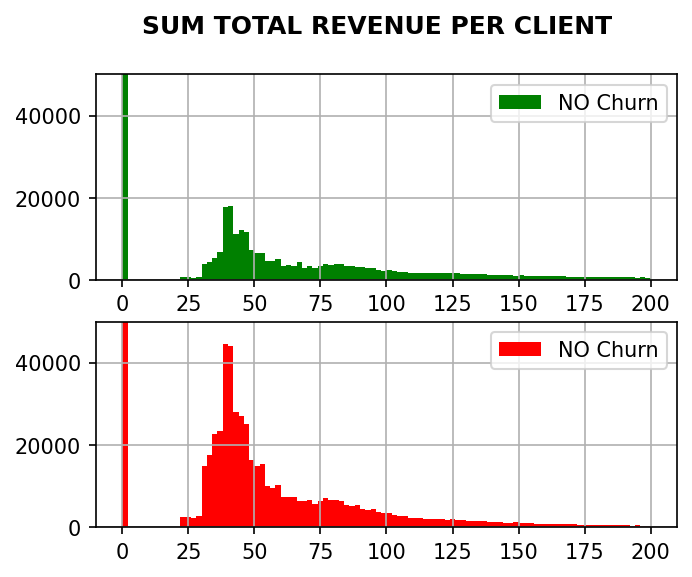

In [ ]:
#Lets USE some Graphic Tools and visualize our data.

#Let's analize some columns at the time. 
#When we see the statistics, we see that even though there's a MAX of 235804.530000 for NOT CHURNING REVENUE. It's QUITE an Outlier. 
#We will limit the range of our customer that havent Churned 
#(which we defined as people that bought from us but didn't buy again in 4 months)
# Let's limit the range of our histogram so that outliers don't affect our visualization

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(2, figsize=(5,4),dpi=150)
fig.suptitle('SUM TOTAL REVENUE PER CLIENT', weight='bold', fontsize=12)
#plt.xlabel('Date', weight='bold',fontsize=12)
#primer grafico
axs[0].hist(NO_CHURN_V['sum_tot_revenue'], color='green', range=(0,200), bins=100, label='NO Churn')
axs[0].legend(loc='best')
axs[0].set_ylim(0,50000)

#SEGUNDO GRAFICO
axs[1].hist(CHURN_V['sum_tot_revenue'], color='red', range=(0,200), bins=100, label='NO Churn')
axs[1].set_ylim(0,50000)
axs[1].legend(loc='best')
plt.legend(loc='best')

plt.show()

#From this histogram we see that we have a LOT of people browsing the website but not buying anything, hence not reporting revenue. 
#We see that we start having sales at values above $20 and that our most concentrated revenue is around $35 per NO CHURNING USER
#Then most of the revenue is concentrated within values up to 200 dollars (euros, or whatever monetary unit)

#For CHURNING USERS. As before, a lot of people browsing the website but not buying anything.
#Here we see that both distributions are quite simmilar. 
#This one however looks bigger because - spoiler - the frequencies of churning and not churning is not balanced. 

#THE MAIN CONCLUTION FROM THIS PLOT IS THAT, EVEN THOUGH WE HAVE TWO DIFFERENT TYPES OF CUSTOMERS, MEANING CHURN AND NO-CHURN CUSTOMERS.
#BOTH OF THEM ARE DISTRIBUTED QUITE SIMILARY. THE REVENUE THAT WE GET FROM BOTH TYPES OF CLIENT IS SIMMILAR.
#ONCE AGAIN, IT LOOKS THAT WE HAVE WAY MORE CONCENTRARED WITHIN NO-CHURN, BUT WHAT WE HAVE TO UNDERSTAND IS THAT WE, HAVE 70% CHURN AND 30% NO CHURN.

#First anticipated conclution? Both CHURNING AND NOT CHURNING CUSTOMERS are simmilar. They provide simmilar revenues.
# Actions should be made to retain churners because their impact in the company's finance is not marginal. 



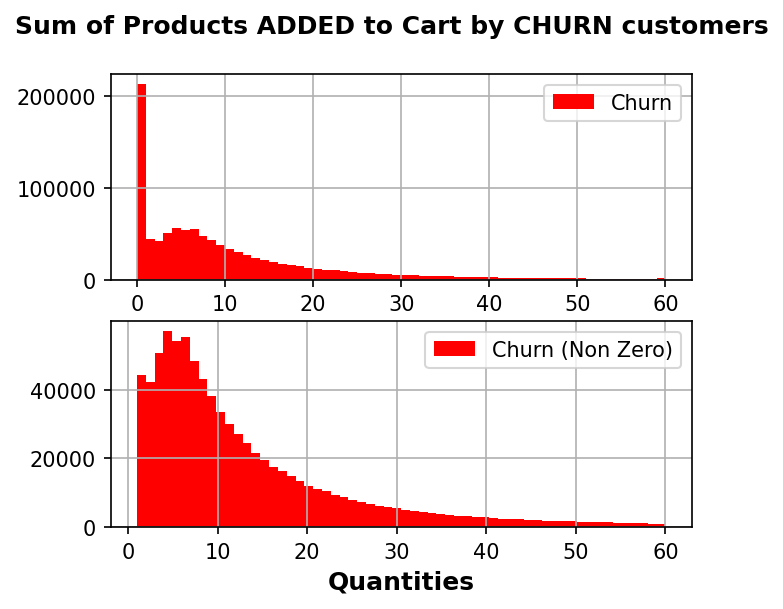

In [ ]:
#Lets analyze how many products were added to the cart. FOR CHURNING CUSTOMERS. again, a lot of people not adding anything (hence not buying)

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(2, figsize=(5,4),dpi=150)
fig.suptitle('Sum of Products ADDED to Cart by CHURN customers', weight='bold', fontsize=12)
plt.xlabel('Quantities', weight='bold',fontsize=12)
#primer grafico
axs[0].hist(CHURN_V['sum_products_added_to_cart'], color='red', range=(0,60), bins=60, label='Churn')
axs[0].legend(loc='best')

#SEGUNDO GRAFICO
axs[1].hist(CHURN_V['sum_products_added_to_cart'], color='red',range=(1,60), bins=60, label='Churn (Non Zero)')
axs[1].legend(loc='best')
plt.legend(loc='best')

plt.show()
#plt.hist(CHURN_V['sum_products_added_to_cart'], range=(0,50), bins=100, color='red')

# We see that the most important concentration of products added is up to 10 products.
# Same graph is done below but leaving not customers out.

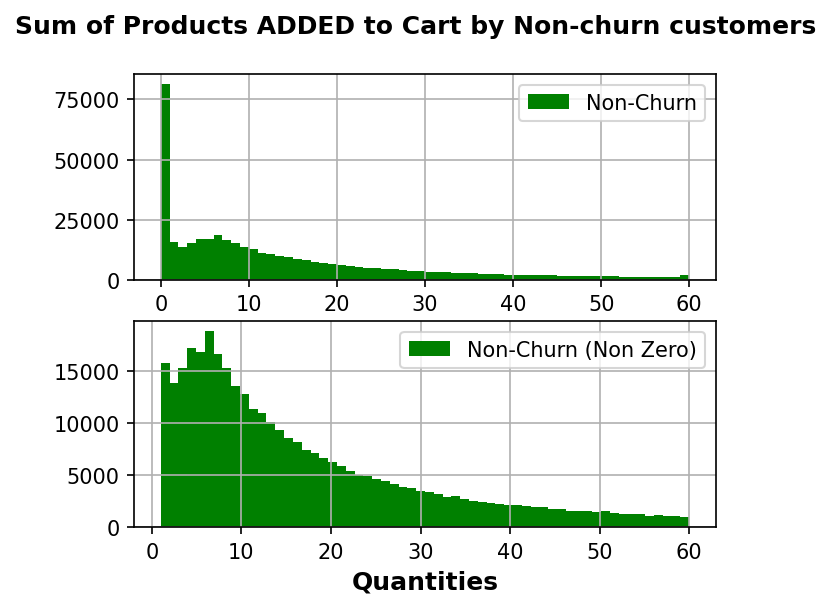

In [ ]:
#What about the product added for NON CHURNING customers? We are going to do the same analysis.

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(2, figsize=(5,4),dpi=150)
fig.suptitle('Sum of Products ADDED to Cart by Non-churn customers', weight='bold', fontsize=12)
plt.xlabel('Quantities', weight='bold',fontsize=12)
#primer grafico
axs[0].hist(NO_CHURN_V['sum_products_added_to_cart'], color='green', range=(0,60), bins=60, label='Non-Churn')
axs[0].legend(loc='best')

#SEGUNDO GRAFICO
axs[1].hist(NO_CHURN_V['sum_products_added_to_cart'], color='green',range=(1,60), bins=60, label='Non-Churn (Non Zero)')
axs[1].legend(loc='best')
plt.legend(loc='best')

plt.show()

# Once again, and as shown in the previous graph of REVENUE. Both distributions of Churning and Not churning Customers seem to be similar. 

In [ ]:
#When we analize both groups, churning and not churning customers we see that there are not significant differences.
# We mean that, both groups imply a revenue of about the same amount. We now need to see how many PRODUCTS do they actually buy.
# We have to analyze what is their actual consumer behaviour. 

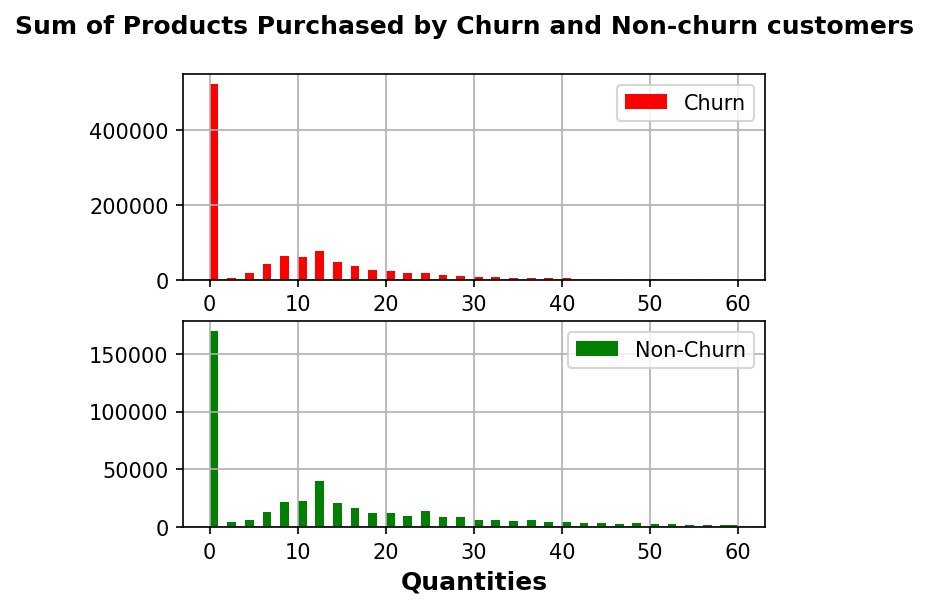

In [ ]:
#Let's see how they buy products. 

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(2, figsize=(5,4),dpi=150)
fig.suptitle('Sum of Products Purchased by Churn and Non-churn customers', weight='bold', fontsize=12)
plt.xlabel('Quantities', weight='bold',fontsize=12)
#primer grafico
axs[0].hist(CHURN_V['sum_prod_quan_pur'], color='red', range=(0,60), bins=60, label='Churn')
axs[0].legend(loc='best')

#SEGUNDO GRAFICO
axs[1].hist(NO_CHURN_V['sum_prod_quan_pur'], color='green',range=(0,60), bins=60, label='Non-Churn')
axs[1].legend(loc='best')
plt.legend(loc='best')

plt.show()

#Once again, both types of customers look quite simmilar. On the one hand there are a lot of users that are not buying anything
#Distributions again are quite simmilar. 

(1.0, 5000.0)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


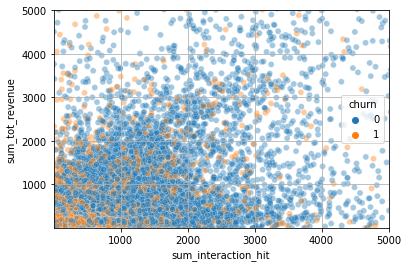

In [ ]:
# When trying to analyze the relationships between the variables with Scatterplots we wanted to look for some microeconomic insights.
# In this graph we analyze Interactions and Revenue. 
# Although, there seems to be a POSITIVE relation for NON CHURNING customers. (more interactions, more revenue), 
# the amount of information is quite big that not clear relationship can be stablished. 
# To get a clear idea of this we will use a Correlation matrix and heat map
 

sns.scatterplot(x="sum_interaction_hit", y="sum_tot_revenue", alpha=0.4, data=df_v, hue='churn')
plt.ylim(1,5000)
plt.xlim(1,5000)


Text(0.5, 1.0, 'Correlation Heatmap')

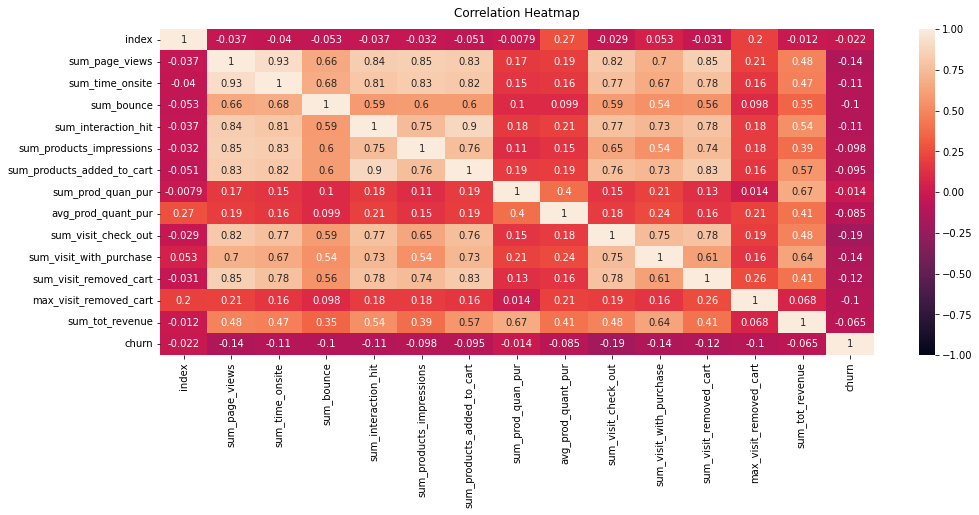

In [ ]:
#HEATMAP WITH CORRELATIONS

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_v.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

#What can we take from this heatmap? 
# In order to avoid being overwhelmed with info, we'll concentrate our analysis in Churn. Can observe the following:
# All the variables seem to have a NEGATIVE CORRELATION WITH CHURN. 
# It make sense that the "good" things for the company are negative correlated with Churn. But not the positive ones.
# Hence; it makes microeconomic sense that variables like: 
# 1) SUM_PAGE_VIEWS
# 2) SUM_TIME_INSITE
# 3) SUM_INTERACTION_HIT
# 4) SUM PRODUCTS_IMPRESSIONS
# 5) SUM_PRODUCTS_ADDED_TO_CART
# 6) SUM_PROD_QUAN_PUR
# 7) AVG_PROD_QUANT_PUR
# 8) SUM_VISIT_CHECK_OUT
# 9) SUM_VISIT_WITH_PURCHASE
# 10) SUM_TOT_REVENUE
# All these variables are making the churn less likely and it goes in hand with Microeconomic Theory and Consumer Behaviour.
# Meaning that by instance, Higher VISITS WITH CHECKOUT, means the customer buys something that makes him/her happier. 
# Hence, lower correlation with Churn (1 in codification)
# HOWEVER, it does not go hand on hand with microeconomic theory the following:
# 1) MAX_VISIT_REMOVED_CART
# 2) SUM_VISIT_REMOVED_CART
# 3) BOUNCE
# The higher the products removed, higher the unhappines, higher the likelihood of churning. 
# Therefore, the named variables should be removed because they make no sense within microeconomic theory. 

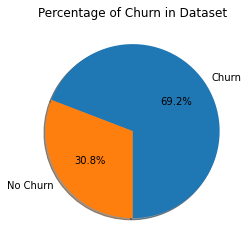

In [ ]:
# After doing some Exploratory Data Analysis and some correlations. Let's analyze how are composed our Churning and Not churning customers.
#Graph on Churn/No Churn
sizes = df['churn'].value_counts(sort = True)
labels = ['Churn', 'No Churn']
plt.pie(x=sizes,autopct='%1.1f%%', shadow=True, startangle=270,labels=labels)
plt.title('Percentage of Churn in Dataset')
plt.show()

#We cam teel that the Churn rate is almost 70%, so quite high. Which means that most of our customers are leaving our service.
# We have defined the churn as the client that bought from us but after 4 months hasn't bought from us again. 
# The definition for the churn was given since no further information on the good/service was provided and 4 months seemed to be a quite reasonable time frame. 

In [ ]:
#Quantitative data on the Churn and No churn Customers

CLASS_NO_CHURN, CLASS_CHURN = df['churn'].value_counts()

# Separate class
NO_CHURN = df[df['churn'] == 0]
CHURN = df[df['churn'] == 1]

# print the shape of the class
print('NO CHURN:', NO_CHURN.shape)
print('CHURN:', CHURN.shape)

# We can see here that quite more customers are churning. 

NO CHURN: (471832, 21)
CHURN: (1058472, 21)


In [ ]:
#Since we can tell that the dataset is NOT BALANCED, because most of our observations land on Churn.
# Then, if we were to model with this data, since the variables(features) are pointing to the Churn site, we would get the wrong conclutions.
# We have to train our dataset with BALANCED INFORMATION. To do so, we decice to UNDERSAMPLE.
#Undersampling is the best solution when we have a lot of data, which is our case.

CHURN_UNDER = CHURN.sample(CLASS_CHURN)

df_b = pd.concat([CHURN_UNDER, NO_CHURN], axis=0)

print("total class of 1 and0:",CHURN_UNDER['churn'].value_counts())

total class of 1 and0: 1    471832
Name: churn, dtype: int64


In [ ]:
#Finally, when we have the two subdatasets - Churn and No Churn - both with the same dimention, it means that it is balanced.

print(CHURN_UNDER.shape, NO_CHURN.shape)

(471832, 21) (471832, 21)


In [ ]:
# Here I have my balanced dataset. Now I can used the model 
df_b

,customerId,first_visit,sum_page_views,sum_time_onsite,sum_bounce,sum_interaction_hit,sum_products_impressions,sum_products_added_to_cart,sum_prod_quan_pur,avg_prod_quant_pur,...,sum_visit_with_purchase,sum_visit_removed_cart,max_visit_removed_cart,sum_tot_revenue,churn,customer_age,revenue_x_hit,avg_price,timexpurchase,product_x_hit
1477598,RtoZNRhI4YpwKybjZFtYRQ==,2021-02-09,56.0,3556.0,0.0,117,53,27,32.0,32.0,...,1,0,0,91.500,1,402 days,1.278689,2.859375,0.000281,3.65625
439425,b2SvdrwBFh6gChtYB3jjmw==,2020-09-02,5.0,47.0,0.0,3,0,1,0.0,0.0,...,0,0,0,0.000,1,562 days,inf,4.693914,0.000000,inf
858029,FYiWB9FfiB04BWZ0g+Mc7A==,2021-04-24,3.0,204.0,0.0,6,0,0,6.0,6.0,...,1,0,0,38.085,1,328 days,0.157542,6.347500,0.004902,1.00000
662673,Ez67/Uh03Ty7vd/qOndgfA==,2020-04-29,20.0,451.0,0.0,4,171,1,0.0,0.0,...,0,0,0,0.000,1,688 days,inf,4.693914,0.000000,inf
689426,sW57tgsMKMjfERy5/+nbcw==,2020-12-12,25.0,1302.0,0.0,26,383,7,0.0,0.0,...,0,1,1,0.000,1,461 days,inf,4.693914,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530293,KuqEhlKuiQt3Hjdd/SgAnA==,2020-04-09,379.0,9779.0,2.0,261,2656,36,40.0,20.0,...,2,4,1,164.190,0,708 days,1.589622,4.104750,0.000205,6.52500
1530294,9j6Fhtc2Ko/cM+tFTb5j7g==,2022-01-14,77.0,3432.0,0.0,86,1080,43,40.0,40.0,...,1,2,1,164.100,0,63 days,0.524071,4.102500,0.000291,2.15000
1530295,Db7ZEm3XVKrYymqEE3xAKQ==,2020-11-16,7.0,2446.0,0.0,19,0,0,40.0,40.0,...,1,0,0,178.965,0,487 days,0.106166,4.474125,0.000409,0.47500
1530297,2qhb5/JUUtuHqR2nDbbkzw==,2022-02-21,152.0,6660.0,0.0,165,998,28,40.0,40.0,...,1,1,1,58.380,0,25 days,2.826310,1.459500,0.000150,4.12500


MODEL REPAIRING


In [ ]:
df_b = df_b.reset_index()


In [ ]:
#Drop unnecessary column "CUSTOMERID" but also eliminating the ones that we thought that had no Microeconomic sense
df_b = df_b.drop(columns=['customerId','max_visit_removed_cart','sum_visit_removed_cart','sum_bounce'], axis=1)
df_b.head()

,index,first_visit,sum_page_views,sum_time_onsite,sum_interaction_hit,sum_products_impressions,sum_products_added_to_cart,sum_prod_quan_pur,avg_prod_quant_pur,sum_visit_check_out,sum_visit_with_purchase,sum_tot_revenue,churn,customer_age,revenue_x_hit,avg_price,timexpurchase,product_x_hit
0,1477598,2021-02-09,56.0,3556.0,117,53,27,32.0,32.0,1,1,91.500,1,402 days,1.278689,2.859375,0.000281,3.65625
1,439425,2020-09-02,5.0,47.0,3,0,1,0.0,0.0,1,0,0.000,1,562 days,inf,4.693914,0.000000,inf
2,858029,2021-04-24,3.0,204.0,6,0,0,6.0,6.0,1,1,38.085,1,328 days,0.157542,6.347500,0.004902,1.00000
3,662673,2020-04-29,20.0,451.0,4,171,1,0.0,0.0,0,0,0.000,1,688 days,inf,4.693914,0.000000,inf
4,689426,2020-12-12,25.0,1302.0,26,383,7,0.0,0.0,1,0,0.000,1,461 days,inf,4.693914,0.000000,inf


In [ ]:
# Fix customer age
df_b.customer_age = df_b.customer_age.apply(lambda x: str(x))

df_b.customer_age = df_b.customer_age.str.split('days 00:00:00')

array = []

for i in df_b.customer_age.values.tolist():
  array.append(i[0])

array1 = []

for i in range(len(array)):
  array1.append(int(array[i]))

df_b.customer_age = array1

Let's use our balanced dataset to create a model using logistic regression.


In [ ]:
#Logistic Regression is useful when we have a classification problem because of a Binomial distributed variable, which means:
#There are 2 possible escenarios.  Churn and No Churn.
from sklearn.linear_model import LogisticRegression


In [ ]:
#Replace infinite and NAT values in dataset
df_b = df_b.replace(np.inf, 0, inplace=False)

In [ ]:
#Splitting the Dataset. I want to give the model SOME data and then test how it does on data that it has not seen before. 
Y = df_b['churn'].values
df_b.drop("first_visit", axis=1, inplace=True)
X = df_b.drop(labels = ['churn'],axis = 1)
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

In [ ]:
# I fit the model 
from sklearn import metrics
model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=3000)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

In [ ]:
# Fitting Logistic Regression to the Training set
classifier = LogisticRegression(random_state = 0)
fit = classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
results = pd.DataFrame([['Logistic Regression', 
acc, prec, rec, f1, f2]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall', 'F1 Score', 
'F2 Score'])
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.792734   0.763653  0.847382  0.803342  0.829199


In [ ]:
#The following are the actual coefficients stimated by the logistic model. 
#The positive sign in them indicate the higher probability of Churn. The negative sign indicates that it decreases the probabiliy of churn.
coef = fit.coef_[0]
print(coef)


[-1.03708118e-06 -1.01237936e-02  1.23677040e-05  1.73456109e-03
  1.54228428e-04 -1.34295117e-04 -3.98840781e-04  1.04793381e-03
 -1.14970422e-03 -2.57230930e-04 -7.85880785e-03  5.53072583e-03
  1.74373956e-04 -1.38330475e-03 -2.13530215e-08  4.80311643e-04]


In [ ]:
X_train.columns

#POSSITIVE COEFFICIENTS: 
# 1) 5.53072583e-03 = CUSTOMER AGE. Biggest positive coefficients belongs to CUSTOMER AGE. This means that the long is a customer with the service, the more likely to leave it. 
# - Big problem for the company. No way to get loyalty rewards program. People get bored?  NETFLIX CASE https://taketonews.com/netflix-is-responding-to-the-loss-of-customers/
# 2) 4.80311643e-04 = Product_X_HIT is second largest positive coefficient.
# Let's remember that we created it like product_x_hit = sum_interaction_hit / sum_prod_quan_pur.
# Hence, the higher the coefficient, the higher the time I am spending to purchase something. Higher likelihood to get bored and to quit. 
# 3) 1.74373956e-04 = Revenue_x_hit = sum_interaction_hit / sum_tot_revenue. The smaller the coefficient the "happier" I am (Cause I buy more)
# Then, the larger, the unhappier I am. The more likely to Churn. 
# 4) 1.73456109e-03 = SUM_INTERACTION_HIT. Not easily logical. More I interact. More I want to churn. Why? Tireness? Ansiety? 
# 5) 1.54228428e-04 = SUM_PRODUCT IMPRESSIONS. The more I read, the more I get overwhelmed. The less harder the decision. The higher the churn. 
# More about this: The Paradox of Choice. Quick overview https://en.wikipedia.org/wiki/The_Paradox_of_Choice
# 6) 1.23677040e-05 = SUM_TIME_ONSITE. Same as before
# 7) 1.04793381e-03 = AVG_PROD_QUANT_PUR NO SENSE. Only if we were taking about Necessity goods (quasilinear). Weird.  (Multicolineallity more likely)


# NEGATIVE COEFFICIENTS
# 1) -7.85880785e-03 = SUM_TOT_REVENUE. The more I spend. The happier. The less likely to churn. Perfect microeconomic sense. 
# 2) -3.98840781e-04 = SUM_PROD_QUAN_PURCHASE. Same as before. 
# 3) -2.57230930e-0 = SUM VISIT WITH PURCHASE. Same as before.
# 4) -2.13530215e-08 = timexpurchase = sum_visit_with_purchase /sum_time_onsite. Higher should be happier (more purchases in less time) 
# Happier makes me want to stay. I don't Churn. 
# 5) -1.38330475e-03 = AVG PRICE. The lower average price, the happier. The less likelyhood to churn.
# 6) -1.34295117e-04 = sum_products_added_to_cart. The more products I put in the car. The more interested. The less churn. 
# 7) -1.14970422e-03 = sum_visit_check_out. Same as before
# 8) -1.01237936e-02 = SUM_page_views. More atracted customer. Less churn. No sense with previous behaviour in 5 and 6 from Possitive. 



Index(['index', 'sum_page_views', 'sum_time_onsite', 'sum_interaction_hit',
       'sum_products_impressions', 'sum_products_added_to_cart',
       'sum_prod_quan_pur', 'avg_prod_quant_pur', 'sum_visit_check_out',
       'sum_visit_with_purchase', 'sum_tot_revenue', 'customer_age',
       'revenue_x_hit', 'avg_price', 'timexpurchase', 'product_x_hit'],
      dtype='object')

In [ ]:
#Here we will use a Confution Matrix to see how many times we predicted Churn or No Churn in the right way
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[69717, 24728],
       [14390, 79898]])

Text(0.5, 257.44, 'Predicted label')

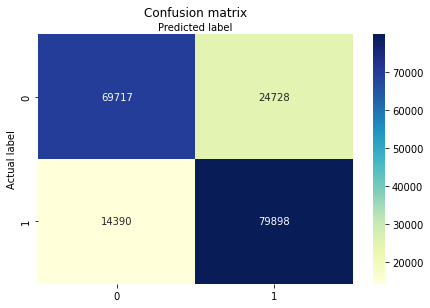

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#What this matrix, that we have converted into a heatmap is telling us is that:
#On 67901 cases we predicted NO CHURN accurately
#On 79382 we predicted CHURN accurately 

#The important thing from the matrix is actually the errors. In this case, in 26544 cases we predicted NO CHURN when the custumer actually CHURNED.
#The other error is when we preidcted CHURN in 14906 cases but it was no Churn. This error is BAD, but not as bad as the previous one.
#Why? Because even though our company might be spending money in retaining clients that are actually not leaving, in the first case we are not doing anything to predict clients that are actually leaving.


In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

#We have created a quite accurate predictive model, with approximately 80% accuracy in predicting the behavior of the customers. 


Accuracy: 0.7927336501830629
Precision: 0.7636533939938447
Recall: 0.847382487697268


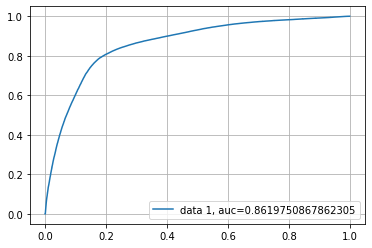

In [ ]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#Here we try to get the P-VALUES to see if what we obtained was significative
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.feature_selection import chi2
data = fetch_20newsgroups_vectorized()
X_p, y_p = X, Y
scores, pvalues = chi2(X_p, y_p)
pvalues

#Since all the P-values<0,05, we can tell that they're all significative and they can be used for the analysis. 
#Then, probabilities of a customer churning or not churning will of course depend of the coefficient that will go with the values that we have estimated. 

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.41133011e-50, 7.14200883e-01, 0.00000000e+00])